In [1]:
import datetime as dt
import csv
import pandas as pd
import networkx as nx

In [2]:
vaccine_terms = 'shot|vaccine|vacine|vacines|vaccines|vaccinate|vaccination|vaccinations|vaccinated|vaccinating|vaxxed|vaxx|vax|\
unvaccinated|unvaxxed|antivaxx|antivaccination|anti|\
moderna|pfizer|J&J|immune|immunize|immunizes|immunized|immunization|immunizations'
vaccine_terms_list= vaccine_terms.split('|')

In [2]:
# data_path = '/content/drive/MyDrive/math168_project/data/08_31.csv'
data_path = '/Volumes/GoogleDrive-105418601834042090131/My Drive/math168_project/data/'

In [56]:
import os
import glob
  
# csv_files = glob.glob(os.path.join(data_path, "*.csv"))

# read the csv file individually
df = pd.read_csv(data_path, dtype="str")
      
# print the location and filename
df = df[['user_id', 'text', 'created_at', 'id', 'in_reply_to_screen_name', 'retweet_screen_name', 'user_screen_name']]
    
# either a reply or a retweet
df = df.dropna(subset=['in_reply_to_screen_name', 'retweet_screen_name'], how='all')
df = df[df.text.str.contains(vaccine_terms)]
    
df['target_user'] = df['in_reply_to_screen_name'].fillna('') + df['retweet_screen_name'].fillna('')
    
# make graph
# G = nx.from_pandas_edgelist(df, 'user_screen_name', 'target_user', create_using=nx.MultiGraph())
    
# save the updated csv to the same directory - decide on a naming convention for these files
# currently it is {original_file_name}_twitter.csv
f_name, _ = os.path.splitext(data_path)
df.to_csv(f_name+'_twitter.csv', index=False, encoding='utf-8-sig')



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [61]:
# merge all updated data together
# get all csv_files in the directory
data_path2 = '/content/drive/MyDrive/math168_project/data/'
csv_files = glob.glob(os.path.join(data_path2, "*.csv"))

# get all updated dataframes
files = []
for file in csv_files:
  if 'twitter' in file: 
    files.append(file)

# merge
completed_df = pd.concat(map(pd.read_csv, files), ignore_index=True)

# save the completed csv file to the same directory
completed_df.to_csv(data_path2+'completed_twitter_data.csv', index=False, encoding='utf-8-sig')

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/concat.py:304: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  sort=sort,
/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/concat.py:304: DtypeWarning: Columns (0,3) have mixed types.Specify dtype option on import or set low_memory=False.
  sort=sort,


In [62]:
len(completed_df)

2967844

- modularity
- number of nodes


# Louvain Communities

In [4]:
from networkx.algorithms.community import louvain_communities
import matplotlib.pyplot as plt
import numpy as np


### Preliminary trial on the data of 08/11

In [5]:
df = pd.read_csv(data_path + '08_11_twitter.csv', dtype="str")

In [6]:
G = nx.from_pandas_edgelist(df, 'user_screen_name', 'target_user')

In [7]:
comm = louvain_communities(G, seed=42)

In [8]:
largest_comm = sorted(comm, key = len, reverse=True)[0]

## Functions for louvain community

In [9]:
def find_community(G):
    # returns a list of communities, and a filtered list of communities
    comm = louvain_communities(G, seed=42)
    
    # filtering out communities that take up less than 0.01 of the nodes
    filtered_comm = [i for i in comm if len(i) > 0.01*len(G.nodes)]
    return comm, filtered_comm

In [12]:
def daily_louvain_stats(day):
    # returns size of largest and smallest community for the given day
    # and the mean size of communities
    # Note that the communities are filtered to take up at least 0.01 of the nodes
    df = pd.read_csv(data_path + f'08_{day}_twitter.csv', dtype="str")
    G = nx.from_pandas_edgelist(df, 'user_screen_name', 'target_user')
    num = len(G.nodes)
    comm, filtered_comm = find_community(G)
    lengths = np.array([len(i) for i in filtered_comm])
    
    return max(lengths), np.mean(lengths), min(lengths), num



In [13]:
daily_louvain_stats(11)

(9361, 2959.964285714286, 1332, 121588)

### Simple stats (max, min, mean) for the communities for each day

In [17]:
days = np.arange(11, 32)

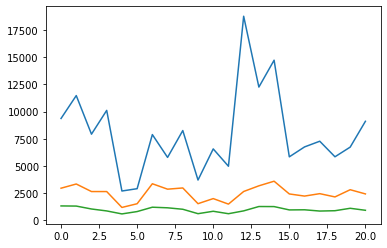

In [16]:
# Gather stats from 8/11 to 8/31
maxes, mins, means, nums = [],[],[], []
for day in days:
    ma, mi, me, num = daily_louvain_stats(day)
    maxes.append(ma)
    mins.append(mi)
    means.append(me)
    nums.append(num)

plt.plot(maxes)
plt.plot(mins)
plt.plot(means)


Text(0.5, 1.0, 'Users against day')

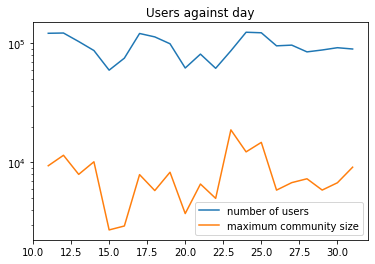

In [18]:
# compares the users vs largest community size per day
plt.plot(days, nums, label='number of users')
plt.plot( days, maxes, label='maximum community size')
plt.yscale('log')
plt.legend()
plt.title('Users against day')

#### Using the similarity score from https://ieeexplore.ieee.org/document/6921553 to try and see how the network changes

In [19]:
# maxsize is an array of the largest communities per day
change_maxsize = np.array([])
# maxsims is an array of the maximum similarity scores per day
change_maxsims = np.array([])
for day in days:
    print(day)
    df_d = pd.read_csv(data_path + f'08_{day}_twitter.csv', dtype="str")
    G_d = nx.from_pandas_edgelist(df_d, 'user_screen_name', 'target_user')
    comm_d , filtered_comm_d = find_community(G_d)
    sims = np.array([])
    for c in filtered_comm_d:
        sim = len(largest_comm.intersection(c)) / max(len(comm), len(c))
        sims = np.append(sims,sim)
    max_sim  = np.max(sims)
    change_maxsims = np.append(change_maxsims, max_sim)
    print(max_sim)

    max_size = len(filtered_comm_d[np.argmax(sims)])
    change_maxsize = np.append(change_maxsize, max_size)
    print(max_size)
    print('-------')
    

11
1.0
9361
-------
12
0.11900191938579655
11462
-------
13
0.15036940460669274
6893
-------
14
0.12371432710415761
5396
-------
15
0.042300449080110096
1664
-------
16
0.05157178038533971
1616
-------
17
0.16600844341549775
7343
-------
18
0.10488193539040996
4165
-------
19
0.12603005332040718
8252
-------
20
0.06895552658264523
3102
-------
21
0.11705055772852382
4815
-------
22
0.11806460959003331
4976
-------
23
0.04563233376792699
3534
-------
24
0.1350049003593597
12244
-------
25
0.14029275808936825
12980
-------
26
0.07938577430102854
2912
-------
27
0.1577574967405476
6545
-------
28
0.14466446644664466
7272
-------
29
0.09705924960162249
4650
-------
30
0.12849485730841664
6732
-------
31
0.12108559498956159
9101
-------


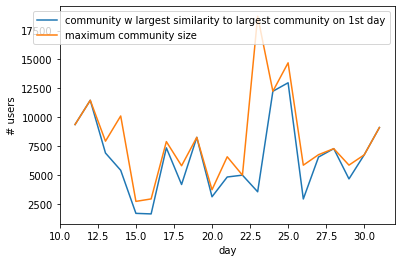

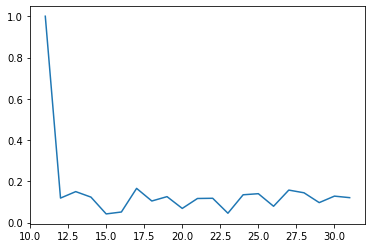

In [20]:
plt.plot(days, change_maxsize, label='community w largest similarity to largest community on 1st day')
plt.plot(days, maxes, label='maximum community size')
plt.legend()
plt.ylabel('# users')
plt.xlabel('day')
plt.show()
plt.plot(days, change_maxsims)

### Trying louvain communities algorithm on entire twitter dataset

In [34]:
df1 = pd.read_csv(data_path + 'CompletedTwitterData.csv', dtype="str")

In [35]:
G1 = nx.from_pandas_edgelist(df1, 'user_screen_name', 'target_user')

In [36]:
from networkx.algorithms.community import louvain_communities

comm = louvain_communities(G1, seed=42)
print(len(comm))

24910


(array([63.,  3.,  2.,  1.,  2.,  3.,  2.,  2.,  1.,  2.,  2.,  1.,  4.,
         0.,  2.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.

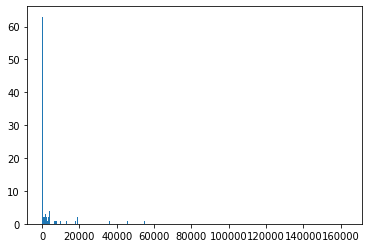

In [38]:
height = {len(x) for x in comm}
plt.hist(list(height), bins=500)

In [ ]:
largest_comm = sorted(comm, key=len)[-1]
G_largest_comm = G1.subgraph(largest_comm)
len(G_largest_comm.nodes)
# nx.draw(G_largest_comm)